In [1]:
#
#  File:
#    NUG_unstructured_ICON_triangles_PyNGL.py
#
#  Synopsis:
#    Illustrates using polygon fill for triangular mesh data.
#
#  Categories:
#    contour plots
#
#  Author:
#    Karin Meier-Fleischer
#  
#  Date of initial publication:
#    February 2016
#
#  Description:
#    This example shows how to create contours of the triangular ICON
#    grid by using polygon fill.
#
#  Effects illustrated:
#    o  Drawing color-filled polygons on a map
#    o  Drawing a custom labelbar on a map
# 
#  Output:
#    A single visualization is produced.
#
#  Notes: The data for this example can be downloaded from 
#    http://www.ncl.ucar.edu/Document/Manuals/NCL_User_Guide/Data/
#     
"""
  NCL User Guide Python Example:   NUG_unstructured_ICON_triangles_PyNGL.py
  Grid type:  unstructured
  Model:      ICON
  Info:       - colored triangles
              - add labelbar (colorbar)
    
 18.02.16    meier-fleischer(at)dkrz.de
"""
from __future__ import print_function
import numpy as np
import math, time, sys, os
import Nio, Ngl

t1 = time.time()                                    #-- retrieve start time

#--  define variables 
diri         = './'
fname        = 'ta_ps_850.nc'                       #-- data path and file name
gname        = 'r2b4_amip.nc'                       #-- grid info file
ffile        = os.path.join(diri, fname)
gfile        = os.path.join(diri, gname)
VarName      = 'ta'                                 #-- variable name       
 
#---Test if files exist
if(not os.path.exists(ffile) or not os.path.exists(gfile)):
    print("You do not have the necessary files to run this example, '{}' and '{}'.".format(ffile, gfile))
    print("You can get the files from the NCL website at:")
    print("http://www.ncl.ucar.edu/Document/Manuals/NCL_User_Guide/Data/")
    sys.exit()

#--  open file and read variables 
f = Nio.open_file(ffile, 'r')                 #-- add data file
g = Nio.open_file(gfile, 'r')                 #-- add grid file (not contained in data file!!!)
 
#-- read a timestep of 'ta'  
variable =  f.variables['ta']                       #-- first time step, lev, ncells
data     =  variable[0,0,:]                         #-- ta [time,lev,ncells]; miss _FillValue
var      =  data - 273.15                           #-- convert to degrees Celsius; miss _FillValue

#-- define _FillValue and missing_value if not existing
missing = -1e20

if not hasattr(var,'_FillValue'):
    var._FillValue  =  missing                       #-- set _FillValue
if not hasattr(var,'missing_value'): 
    var.missing_value =  missing                     #-- set missing_value

varM = np.ma.array(var, mask=np.equal(var,missing)) #-- mask array with missing values 
nummissing = np.count_nonzero(varM.mask)            #-- number of missing values

#-- set data intervals, levels, labels, color indices
varMin, varMax, varInt = -32, 28, 4                 #-- set data minimum, maximum, interval
 
levels   =  list(range(varMin,varMax,varInt))             #-- set levels array
nlevs    =  len(levels)                             #-- number of levels
labels   =  ['{:.2f}'.format(x) for x in levels]    #-- convert list of floats to list of strings

#-- print info to stdout
print('')
print('min/max:          {:0.2f} / {:0.2f}'.format(np.min(varM), np.max(varM)))
print('')
print('varMin:           {:3d}'.format(varMin))
print('varMax:           {:3d}'.format(varMax))
print('varInt:           {:3d}'.format(varInt))
print('')
print('missing_value:    {}'.format(missing))
print('missing values:   {}'.format(nummissing))
#-------------------------------------------------------------------
#-- define the x-, y-values and the polygon points
#-------------------------------------------------------------------
rad2deg = 45./np.arctan(1.)                         #-- radians to degrees

x, y       =  g.variables['clon'][:], g.variables['clat'][:]
vlon, vlat =  g.variables['clon_vertices'][:], g.variables['clat_vertices'][:]

x, y       =  x*rad2deg,  y*rad2deg                 #-- cell center, lon, lat
vlat, vlon =  vlat*rad2deg, vlon * rad2deg          #-- cell latitude/longitude vertices
ncells, nv =  vlon.shape                            #-- ncells: number of cells; nv: number of edges

#-- print information to stdout
print('')
print('cell points:      {}'.format(nv))
print('cells:            {}'.format(ncells))
print('')

#-- rearrange the longitude values to -180.-180.
def rearrange(vlon):
    less_than    = vlon < -180.
    greater_than = vlon >  180.
    vlon[less_than]    = vlon[less_than] + 360.
    vlon[greater_than] = vlon[greater_than] - 360.
    return vlon

vlon = rearrange(vlon)                              #-- set longitude values to -180.-180. degrees

print('min/max vlon:     {} {}'.format(np.min(vlon), np.max(vlon)))
print('min/max vlat:     {} {}'.format(np.min(vlat), np.max(vlat)))
print('')

#-- open a workstation for second plot:  triangles plot
wkres =  Ngl.Resources()
wkres.wkWidth, wkres.wkHeight  =  2500, 2500
wks_type = 'png'
wks_name = "NUG_unstructured_ICON_triangles_PyNGL"
wks      =  Ngl.open_wks(wks_type,wks_name,wkres)

#-- define colormap
colormap =  Ngl.read_colormap_file('WhiteBlueGreenYellowRed')[22::12,:]    #-- RGB ! [256,4] -> [20,4]
                                                  #-- select every 12th color 
colormap[19,:] = [1.,1.,1.,0.]                    #-- white for missing values
print('')
print('levels:           {}'.format(levels))
print('labels:           {}'.format(labels))
print('')
print('nlevs:            {:3d}'.format(nlevs))
print('')

#-- set map resources
mpres                             =  Ngl.Resources()
mpres.nglDraw                     =  False          #-- turn off plot draw and frame advance. We will
mpres.nglFrame                    =  False          #-- do it later after adding subtitles.
mpres.mpGridAndLimbOn             =  False
mpres.mpGeophysicalLineThicknessF =  2.
mpres.pmTitleDisplayMode          = 'Always'
mpres.tiMainString                = 'PyNGL: unstructured grid ICON'

#-- create only a map
map = Ngl.map(wks,mpres)
Ngl.draw(map)

#-- assign and initialize array which will hold the color indices of the cells
gscolors = -1*(np.ones((ncells,),dtype=np.int))     #-- assign array containing zeros; init to transparent: -1

#-- set color index of all cells in between levels
for m in range(nlevs):
    vind = []                                       #-- empty list for color indices
    for i in range(ncells-1):
        if (varM[i] >= levels[m] and varM[i] < levels[m+1]):
           gscolors[i] = m+1    # 1 to nlevs
           vind.append(i)
    print('finished level {:3d}  -- {:5d}   polygons considered - gscolors {:3d}'.format(m, len(vind), m+1))
    del vind

gscolors[varM < varMin]         =  0       #-- set color index for cells less than level[0]
gscolors[varM >= varMax]        = nlevs+1  #-- set color index for cells greater than levels[nlevs-1]
gscolors[np.nonzero(varM.mask)] = -1       #-- set color index for missing locations

#-- set polygon resources
pgres                   =  Ngl.Resources()
pgres.gsEdgesOn         =  True                     #-- draw the edges
pgres.gsFillIndex       =  0                        #-- solid fill
pgres.gsLineColor       = 'black'                   #-- edge line color
pgres.gsLineThicknessF  =  0.7                      #-- line thickness
pgres.gsColors          =  colormap[gscolors,:]     #-- use color array
pgres.gsSegments        =  list(range(0,len(vlon[:,0])*3,3)) #-- define segments array for fast draw

lon1d, lat1d = np.ravel(vlon), np.ravel(vlat)           #-- convert to 1D-arrays

#-- add polygons to map
polyg  = Ngl.add_polygon(wks,map,lon1d,lat1d,pgres)

#-- add a labelbar
lbres                   =  Ngl.Resources()
lbres.vpWidthF          =  0.85
lbres.vpHeightF         =  0.15
lbres.lbOrientation     = 'Horizontal'
lbres.lbFillPattern     = 'SolidFill'
lbres.lbMonoFillPattern =  21                       #-- must be 21 for color solid fill
lbres.lbMonoFillColor   =  False                    #-- use multiple colors
lbres.lbFillColors      =  colormap
lbres.lbLabelFontHeightF=  0.014
lbres.lbLabelAlignment  = 'InteriorEdges'
lbres.lbLabelStrings    =  labels

lb = Ngl.labelbar_ndc(wks,nlevs+1,labels,0.1,0.24,lbres)

#-- maximize and draw the plot and advance the frame
Ngl.draw(map)
Ngl.frame(wks)

#-- get wallclock time
t2 = time.time()
print('')
print('Wallclock time:  {:0.3f} seconds'.format(t2-t1))
print('')

Ngl.end()



min/max:          -34.87 / 21.07

varMin:           -32
varMax:            28
varInt:             4

missing_value:    -1e+20
missing values:   956

cell points:      3
cells:            20480

min/max vlon:     -180.0 180.0
min/max vlat:     -89.99999999999996 89.99999999999997


levels:           [-32, -28, -24, -20, -16, -12, -8, -4, 0, 4, 8, 12, 16, 20, 24]
labels:           ['-32.00', '-28.00', '-24.00', '-20.00', '-16.00', '-12.00', '-8.00', '-4.00', '0.00', '4.00', '8.00', '12.00', '16.00', '20.00', '24.00']

nlevs:             15

finished level   0  --   402   polygons considered - gscolors   1
finished level   1  --   583   polygons considered - gscolors   2
finished level   2  --   447   polygons considered - gscolors   3
finished level   3  --   515   polygons considered - gscolors   4
finished level   4  --   713   polygons considered - gscolors   5
finished level   5  --   952   polygons considered - gscolors   6
finished level   6  --  1075   polygons considered - gscol

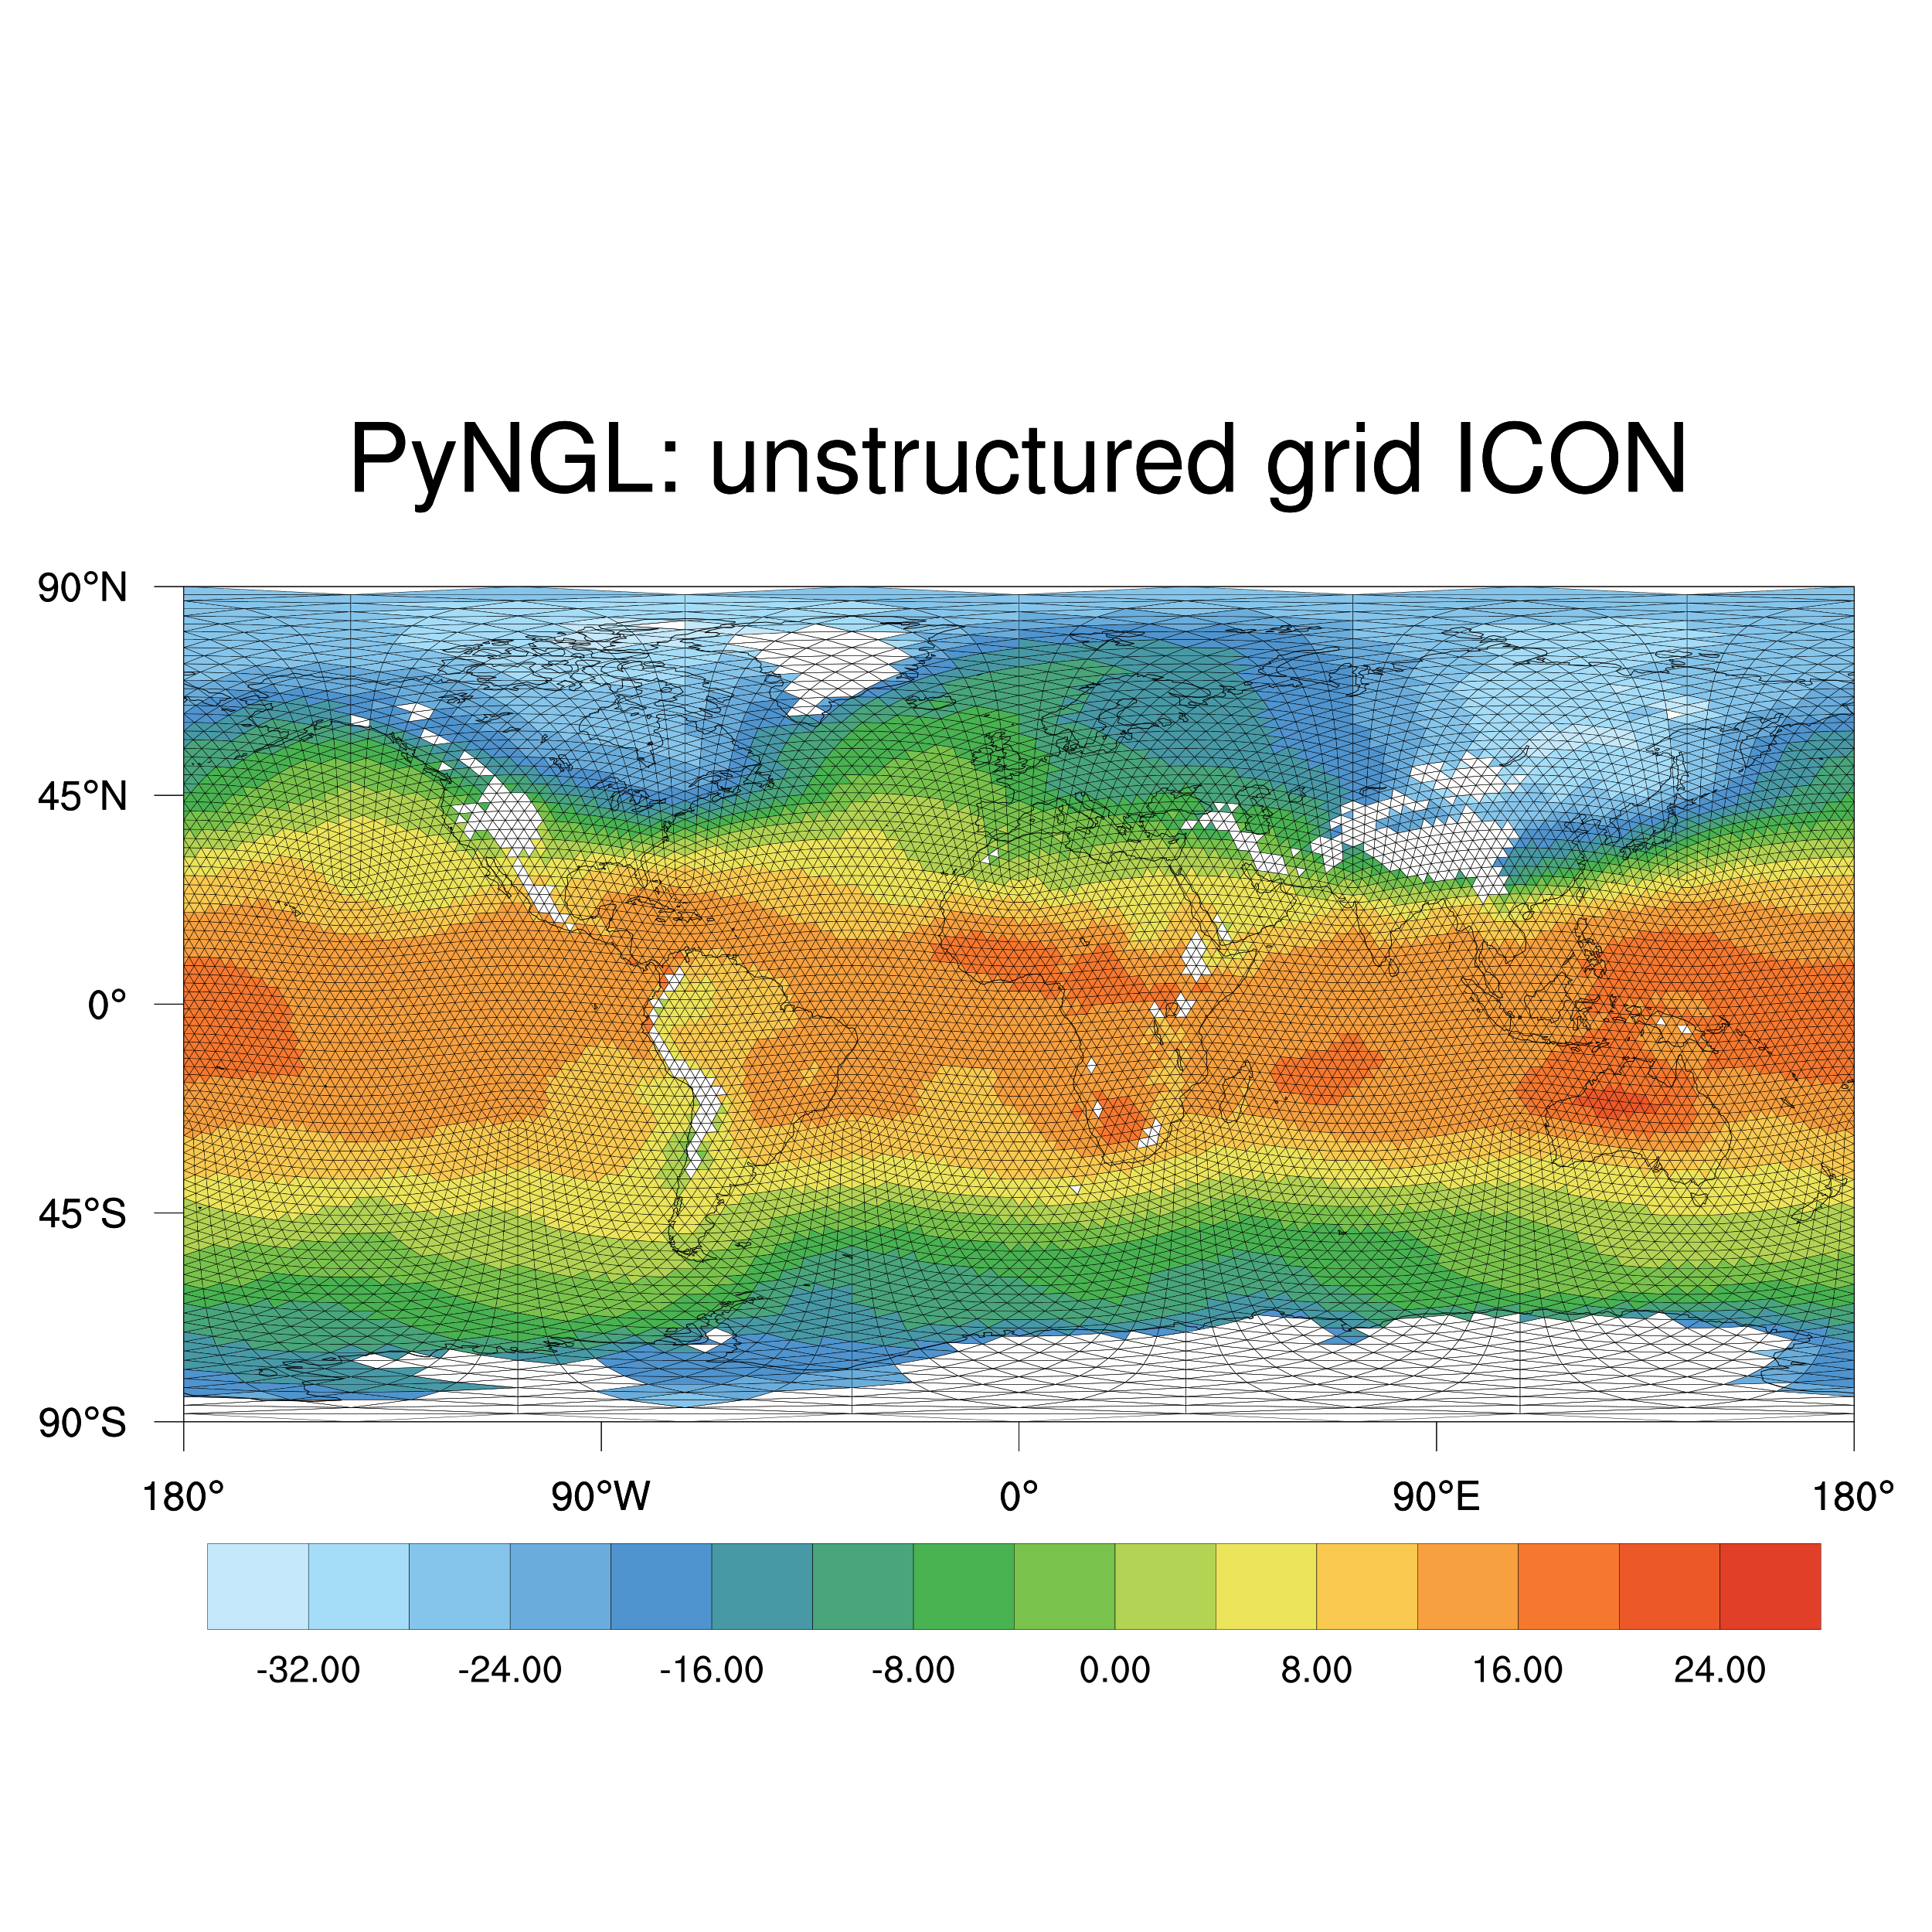